In [2]:
import wntr
# from scripts.segment import *
# from scripts.valves import *
import matplotlib.pyplot as plt

from pylab import rcParams
import pandas as pd
from scripts.bundle_analysis import *
from scripts.plot_utils import *
import seaborn as sns
sns.set(font_scale=1.25,rc={"lines.linewidth": 2})
sns.set_style("white")

In [3]:
wntr.__version__

'0.3.0'

# Load the network

/home/rewu/Documents/research/valves/wntr/epanet/io.py:2173: UserWarning: Not all curves were used in "./data/hill.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


(<matplotlib.collections.PathCollection at 0x7f92874665d0>,
 <matplotlib.collections.LineCollection at 0x7f92874663d0>)

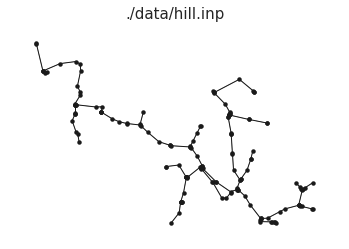

In [3]:
# Create a water network model
inp_file = './data/hill.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.minimum_pressure = 3.5
wn.options.hydraulic.required_pressure = 21

sim = wntr.sim.EpanetSimulator(wn)
init_result = sim.run_sim()

wntr.graphics.plot_network(wn, title=wn.name)

In [4]:
nname2nid = {}
nid2nname = {}
nid2lid = {}

for nid,nname in enumerate(wn.node_name_list):
    nname2nid[nname] = nid
    nid2nname[nid] = nname
    nid2lid[nid] = []
    
lid2nids = {}
lname2lid = {}
lid2lname = {}


for lid,pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    n1_name = pipe.start_node_name
    n2_name = pipe.end_node_name
    lname2lid[pipe.name] = lid
    lid2lname[lid] = pipe.name
    
    nid1,nid2 = nname2nid[n1_name],nname2nid[n2_name]
    lid2nids[lid] = (nid1,nid2)
    
    nid2lid[nid1].append(lid)
    nid2lid[nid2].append(lid)
    
pids = list(lid2lname.keys())
src_pids = [lname2lid['2254665'],lname2lid['8925'],lname2lid['2182239'],
           lname2lid['9440'],lname2lid['8929'],lname2lid['P11']]
src_nids = [nname2nid['ROUND_HILL_FGN']]
valid_pids = list(set(pids)-set(src_pids))
    
pipe_adj_mtx = assemble_pipe_adj_mtx(nid2lid)
pipe_data = get_pipe_df(wn)

TOT_LENGTH = 0
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)  
    TOT_LENGTH+= pipe.length
    
pid2pcost = {}
for nname, item in init_result.node['demand'].items():
#     demand = m3togal(item.values[0])*60 #gal/minute
    demand = item.values[0]
    nid = nname2nid[nname]
    pids = nid2lid[nid]
    for pid in pids:
        if demand >0:
            pid2pcost[pid] = demand/len(pids)
        else:
            pid2pcost[pid] = 0 

# Get the current valve state 

In [5]:
valve_layer = pd.read_csv('./data/valve_layer_hill.csv')
lnames = list(valve_layer['link'])
nnames = list(valve_layer['node'])

valid_nidpids = []
for nname, lname in zip(nnames,lnames):
    nid = nname2nid[nname]
    pid = lname2lid[str(lname)]
    valid_nidpids.append((nid,pid))

valid_nidpids = list (set(valid_nidpids))
print (f'number of valves {len(valid_nidpids)}')

number of valves 48


In [6]:
# add control valves 
src_control_valves = []
for src_pid in src_pids:
    nids = lid2nids[src_pid]
    for nid in nids:
        src_control_valves.append((nid,src_pid))

# Find Valves to Maintain 

## Centrality 

### Calculate edge_betweenness_centrality for every valve

In [7]:
from networkx.algorithms.centrality import edge_betweenness_centrality
vstate = create_valvestates(lid2nids,valid_nidpids,src_control_valves)
segnet = HydroSegmentNet(vstate,src_pids,pid2pcost)
centrality = edge_betweenness_centrality(segnet.G)
centrality = sorted(centrality.items(),key=lambda x: x[1], reverse=True)

In [8]:
centralities = [c for vid, c in centrality]

(0.0, 0.6)

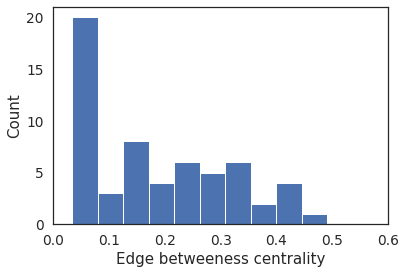

In [9]:
plt.hist(centralities,bins = 10)
plt.xlabel('Edge betweeness centrality')
plt.ylabel('Count')
plt.xlim((0,0.6))
# plt.savefig('./maintain_figures/rh_centrality_hist.png',bbox_inches='tight',dpi=300)

In [10]:
centralities = np.array(centralities)
1-sum(centralities<0.1)/len(centralities)

0.6101694915254237

## Select valves with high centrality to maintain

In [10]:
import collections
centrality = np.array(centrality)
pipe_centrality_dict = collections.defaultdict(int)
valid_valves = centrality[centralities>=0.2]
for sids, val in valid_valves:
    vid = segnet.sids2vid[sids]
    valve = vstate.vreg.vid2v[vid]
    pname = lid2lname[valve.pid]
    pipe_centrality_dict[pname] = max(pipe_centrality_dict[pname],val)

centrality_values = [pipe_centrality_dict[pname] for pname in pipe_data['pipe_names']]

pipe_data['centrality'] = centrality_values

/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [11]:
critical_valves = []
critical_pids = []
critical_nidpids = []
for sids, val in valid_valves:
    vid = segnet.sids2vid[sids]
    valve = vstate.vreg.vid2v[vid]
    critical_valves.append(valve)
    critical_pids.append(valve.pid)
    critical_nidpids.append((valve.nid,valve.pid))

In [12]:
def plot_pipes1(p0,save_name):

    impact0 = pipe_data[pipe_data['pipe_names'].isin(p0)]
    impact0 = impact0.set_index('pipe_names')
    
    ax1 = pipe_data.plot(figsize = (18,10),
                         linewidth=3,
                        column = 'centrality',
                        cmap = 'magma',
                       legend = True,
                        alpha = 1)
#     ax1 = impact0.plot(ax= ax1,
#                         linewidth=5,
#                         column = 'centrality',
#                         cmap = 'magma',
#                        legend = True,
#                         alpha = 1)
#     ax1 = impact1.plot(ax= ax1,
#                         linewidth=4,
#                        color = 'orange',
#                        label = 'Second Degree',
#                         alpha = 1)
#     ax1.legend()
    ax1.axis('off')
#     plt.savefig(save_name,bbox_inches='tight',dpi=300)
#     title = f'''Number of pipes experiencing pressure drop of isolating a pipe with group size {groupsize} '''
#     ax.set_title(title, fontsize=25)
    ax1.plot()

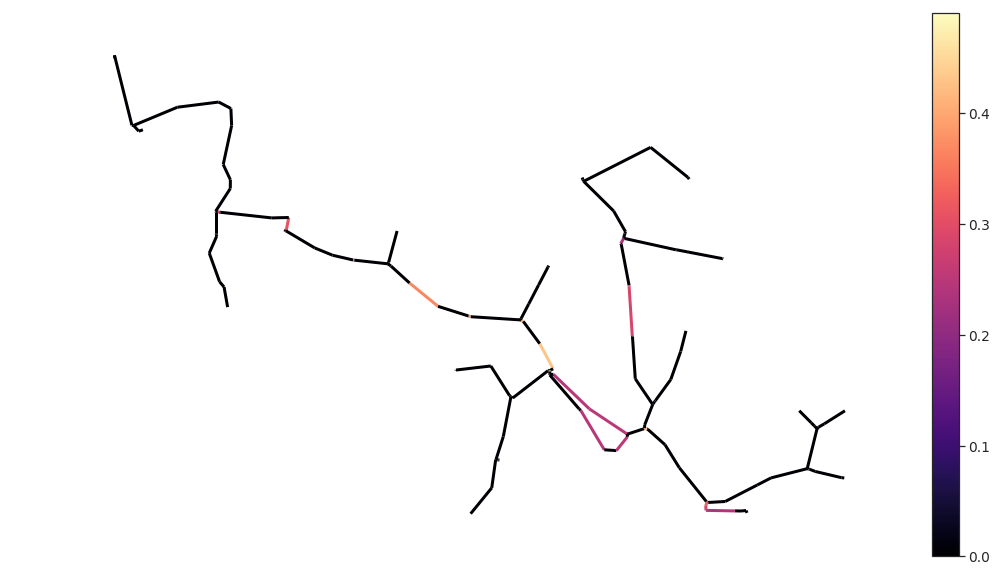

In [15]:
chosen_pnames = [lid2lname[pid] for pid in critical_pids]
plot_pipes1(chosen_pnames,"./maintain_figures/roundhill_centrality_map.png")

In [16]:
def plot_pipes2(p0,save_name):

    impact0 = pipe_data[pipe_data['pipe_names'].isin(p0)]
    impact0 = impact0.set_index('pipe_names')
    
    ax1 = pipe_data.plot(figsize = (18,10),
                         linewidth=3,
                         color = 'black',
                        alpha = 1)
    ax1 = impact0.plot(ax= ax1,
                        linewidth=5,
                       color = 'red',
                       label = 'Pipe with MT valves',
                        alpha = 1)
#     ax1 = impact1.plot(ax= ax1,
#                         linewidth=4,
#                        color = 'orange',
#                        label = 'Second Degree',
#                         alpha = 1)
    ax1.legend()
    ax1.axis('off')
#     plt.savefig(save_name,bbox_inches='tight',dpi=300)
#     title = f'''Number of pipes experiencing pressure drop of isolating a pipe with group size {groupsize} '''
#     ax.set_title(title, fontsize=25)
    ax1.plot()

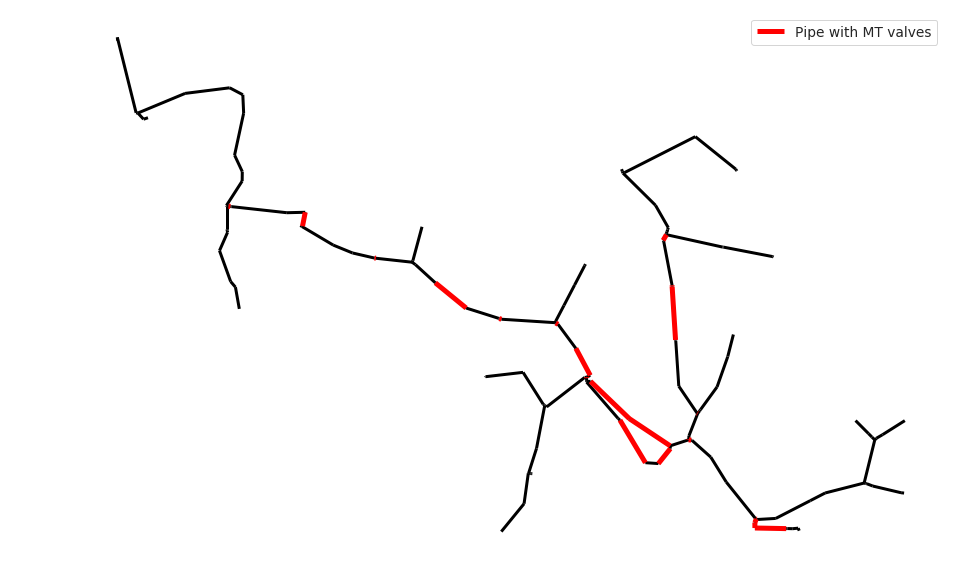

In [17]:
plot_pipes2(chosen_pnames,"./maintain_figures/roundhill_maintained_valves.png")

## risk estimation 

In [13]:
fail_rates = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
num_steps = 100
GLOB_SEG_IMPACT_DICT = {}

In [14]:
from scripts.damage_estimation import evaluate_damages

In [16]:
from scripts.damage_estimation import evaluate_damages
# # designed mt 
mt_pids_opt = set(critical_nidpids+src_control_valves)
other_nidpids = set(valid_nidpids)-mt_pids_opt

save_path = './data/simulation_progress/roundhill_maintain'
    
damage_list_mt = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                     src_pids,src_nids,pid2pcost,GLOB_SEG_IMPACT_DICT,
                     other_nidpids,fail_rates,mt_pids_opt,
                        num_steps = num_steps,save_path = save_path)

number of segment to simulate: 46
number of segment to simulate: 3


/home/rewu/Documents/research/valves/scripts/bundle_analysis.py:122: RuntimeWarning: invalid value encountered in true_divide
  val_diff_ratio = val_diff/init_val*100


number of segment to simulate: 1


Process ForkPoolWorker-31:
Process ForkPoolWorker-44:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Process ForkPoolWorker-37:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Process ForkPoolWorker-45:
Process ForkPoolWorker-42:
Process ForkPoolWorker-32:
Process ForkPoolWorker-43:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self

KeyboardInterrupt: 

  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-41:
KeyboardInterrupt
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/rewu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-3

In [23]:
# random mt 
num_random_mt = len(mt_pids_opt)-len(src_control_valves)
random_idx = np.random.choice(list(range(len(valid_nidpids))),num_random_mt,replace = False)
random_nidpids = [valid_nidpids[idx] for idx in random_idx]+src_control_valves
other_nidpids_rand = list(set(valid_nidpids)-set(random_nidpids))

save_path = './data/simulation_progress/alameda_maintain_random'
damage_list_rand_mt = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                     src_pids,src_nids,pid2pcost,GLOB_SEG_IMPACT_DICT,
                     other_nidpids_rand,fail_rates,random_nidpids,
                        num_steps = num_steps,save_path = save_path)



number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved


In [23]:
# no maintenance 
damage_list_current = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                     src_pids,src_nids,pid2pcost,GLOB_SEG_IMPACT_DICT,
                     valid_nidpids,fail_rates,src_control_valves,
                        num_steps = num_steps,save_path = save_path)



number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 4
number of segment to simulate: 1
dict saved
result saved


In [25]:
from scripts.utils import summarize2df

In [26]:
sim_results = [damage_list_mt[:9],damage_list_rand_mt[:9],damage_list_current[:9]]
valving_types = ['MT-proposed','MT-random','No Maintenance']

# sim_results = [damage_list_mt[:9],damage_list_rand_mt[:9]]
# valving_types = ['MT-proposed','MT-random']

res_dfs = []
for res,vtype in zip(sim_results,valving_types):
    df = summarize2df(res,fail_rates,vtype)
    res_dfs.append(df)
summary_df = pd.concat(res_dfs,ignore_index = True)

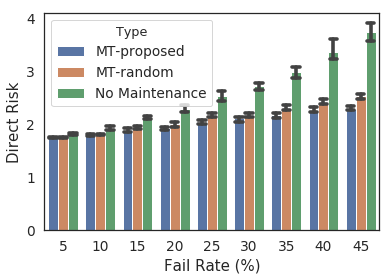

In [29]:
from numpy import median
ax = sns.barplot(x="Fail Rate (%)", y="Direct Risk", hue='Type',
                 data=summary_df, estimator=median,capsize=.2)
# plt.savefig("./maintain_figures/roundhill_maintain_direct_risk.png",bbox_inches='tight',dpi=300)

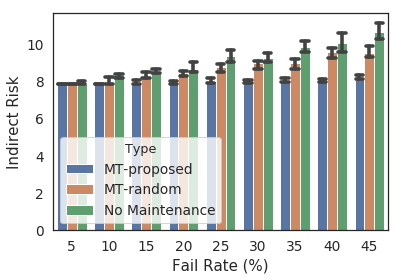

In [30]:
ax = sns.barplot(x="Fail Rate (%)", y="Indirect Risk", hue='Type',
                 data=summary_df, estimator=median,capsize=.2)
# plt.savefig("./maintain_figures/roundhill_maintain_indirect_risk.png",bbox_inches='tight',dpi=300)

In [32]:
deployed_df = summary_df[summary_df['Type'].isin(['No Maintenance'])]
rates = np.array(fail_rates) *100

medians_direct = []
for rate in rates.astype(int):
    selected_df = deployed_df[deployed_df['Fail Rate (%)']==rate]
    medians_direct.append(round(selected_df['Indirect Risk'].std(),2))
medians_direct = np.array(medians_direct)
medians_direct

array([ 0.38,  0.57,  0.91,  0.97,  1.43,  1.55, 22.41,  2.06, 16.11,   nan])

### Various number of valves to maintain 

In [11]:
import collections
def select_critical_valves(mt_percent):
    pipe_centrality_dict = collections.defaultdict(int)
    valid_valves = centrality[:int(len(centrality)*mt_percent)]
    for sids, val in valid_valves:
        vid = segnet.sids2vid[sids]
        valve = vstate.vreg.vid2v[vid]
        pname = lid2lname[valve.pid]
        pipe_centrality_dict[pname] = max(pipe_centrality_dict[pname],val)


    critical_nidpids = []
    for sids, val in valid_valves:
        vid = segnet.sids2vid[sids]
        valve = vstate.vreg.vid2v[vid]
        critical_nidpids.append((valve.nid,valve.pid))
    return critical_nidpids
                            
    


In [25]:
from scripts.damage_estimation import evaluate_damages

maintain_percs = [0.1,0.2,0.3,0.4,0.5]
fail_rates = [0.1,0.2,0.3,0.4,0.5]
num_steps = 1000
GLOB_SEG_IMPACT_DICT = {}

damage_lists_mt = []
damage_lists_rand_mt = []
for mt_perc in maintain_percs:
    print (mt_perc)
    critical_nidpids = select_critical_valves(mt_perc)
    
    # # designed mt 
    mt_pids_opt = set(critical_nidpids+src_control_valves)
    other_nidpids = set(valid_nidpids)-mt_pids_opt
    save_path = './data/simulation_progress/roundhill_maintain_'+str(mt_perc*100)
    damage_lists_mt.append(evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                         src_pids,src_nids,pid2pcost,GLOB_SEG_IMPACT_DICT,
                         other_nidpids,fail_rates,mt_pids_opt,
                            num_steps = num_steps,save_path = save_path))
    
    # random mt 
    num_random_mt = len(mt_pids_opt)-len(src_control_valves)
    random_idx = np.random.choice(list(range(len(valid_nidpids))),num_random_mt,replace = False)
    random_nidpids = [valid_nidpids[idx] for idx in random_idx]+src_control_valves
    other_nidpids_rand = list(set(valid_nidpids)-set(random_nidpids))

    save_path = './data/simulation_progress/alameda_maintain_random_'+str(mt_perc*100)
    damage_lists_rand_mt.append(evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                         src_pids,src_nids,pid2pcost,GLOB_SEG_IMPACT_DICT,
                         other_nidpids_rand,fail_rates,random_nidpids,
                            num_steps = num_steps,save_path = save_path)) 




0.1
number of segment to simulate: 43
number of segment to simulate: 9
number of segment to simulate: 5
number of segment to simulate: 3
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 0
number of segment to simulate: 3
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
numbe

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of s

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved

number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of s

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of s

number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of s

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
dict saved
result saved
number of segment to simulate: 0
number of segment t

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

In [26]:
summary_dfs = []
for i in range(len(damage_lists_mt)):
    sim_results = [damage_lists_mt[i],damage_lists_rand_mt[i]]
    valving_types = ['MT-proposed','MT-random']

    # sim_results = [damage_list_mt[:9],damage_list_rand_mt[:9]]
    # valving_types = ['MT-proposed','MT-random']

    res_dfs = []
    for res,vtype in zip(sim_results,valving_types):
        df = summarize2df(res,fail_rates,vtype)
        res_dfs.append(df)
    summary_dfs.append(pd.concat(res_dfs,ignore_index = True))

In [34]:
rates = np.array(fail_rates) *100
direct_proposed_list,indirect_proposed_list = [],[]
direct_random_list,indirect_random_list = [],[]

for summary_df in summary_dfs:
    proposed_df = summary_df[summary_df['Type'].isin(['MT-proposed'])]
    random_df = summary_df[summary_df['Type'].isin(['MT-random'])]
    
    direct_proposed,indirect_proposed = [],[]
    direct_random,indirect_random = [],[]
    for rate in rates.astype(int):
        selected_df = proposed_df[proposed_df['Fail Rate (%)']==rate]
        direct_proposed.append(round(selected_df['Direct Risk'].mean(),2))
        indirect_proposed.append(round(selected_df['Indirect Risk'].mean(),2))
        
        selected_df = random_df[random_df['Fail Rate (%)']==rate]
        direct_random.append(round(selected_df['Direct Risk'].mean(),2))
        indirect_random.append(round(selected_df['Indirect Risk'].mean(),2))
    direct_proposed_list.append(direct_proposed)
    indirect_proposed_list.append(indirect_proposed)
    direct_random_list.append(direct_random)
    indirect_random_list.append(indirect_random)
    
        


In [35]:
def get_plot_df(mt_perc,direct,indirect,vtype):
    direct_risks,indirect_risks,tot_risks = [],[],[]
    fail_rate_list,maintain_perc_list = [], []
    for p, direct,indirect in zip(mt_perc,direct,indirect):
        direct_risks += direct
        indirect_risks += indirect
        fail_rate_list += list(rates)
        maintain_perc_list += len(direct)*[p*100]

    df_dict = {'Direct Risk': direct_risks,
                   'Indirect Risk': indirect_risks,
                   'Fail Rate (%)':fail_rate_list,
                   'Mtn Perc (%)': maintain_perc_list,
               'Type': len(direct_risks)*[vtype]
        }
    df_risk = pd.DataFrame.from_dict(df_dict)
    return df_risk
    
    

In [36]:
valving_types = ['MT-proposed','MT-random']
directs = [direct_proposed_list,direct_random_list]
indirects = [indirect_proposed_list,indirect_random_list]
df_risk = []
for direct,indirect,vtype in zip(directs,indirects,valving_types):
    df = get_plot_df(maintain_percs,direct,indirect,vtype)
    df_risk.append(df)
df_risk = pd.concat(df_risk,ignore_index = True)

In [ ]:
selected_df = df_risk[df_risk['Fail Rate (%)'].isin([5.0])]
selected_df

In [38]:
selected_df = df_risk[df_risk['Mtn Perc (%)'].isin([10.0,20.0,30.0])]
sns.set(font_scale=1.1,rc={"lines.linewidth": 1.25,'lines.markersize': 7})
sns.set_style("white")

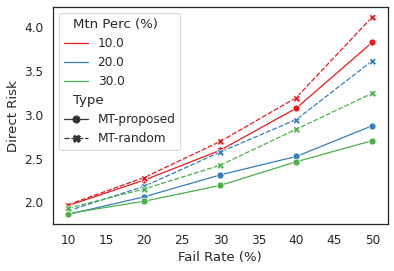

In [41]:
sns.lineplot(data=selected_df,x='Fail Rate (%)',y = 'Direct Risk' ,
             hue = 'Mtn Perc (%)', style = "Type",palette="Set1",markers=True)
plt.savefig("./maintain_figures/rh_various_size_direct.png",bbox_inches='tight',dpi=300)

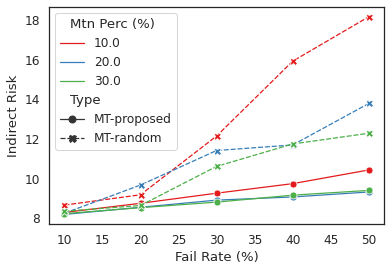

In [42]:
sns.lineplot(data=selected_df,x='Fail Rate (%)',y = 'Indirect Risk' ,
             hue = 'Mtn Perc (%)', style = "Type",palette="Set1",
             markers=True, sizes=(.25, 2.5))
plt.savefig("./maintain_figures/rh_various_size_indirect.png",bbox_inches='tight',dpi=300)